# ROC on openpifpaf

In [9]:
from matplotlib import pyplot as plt
import numpy as np

def plot_roc(current_result, label, ax=None):
    ax = ax or plt.figure().gca()
    x = current_result["FP"]/(current_result["FP"]+current_result["TN"])
    y = current_result["TP"]/(current_result["TP"]+current_result["FN"])
    ax.plot(x, y, linestyle="-", linewidth=1, markersize=5, marker=".", label=label)
    index=10
    ax.plot(x[index], y[index], markersize=10, marker=".", color="green")
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.axis("equal")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_box_aspect(1)
    ax.set_title(f"ROC ball detection from PIFPAF")
    ax.legend()
    return ax

In [10]:
from matplotlib import pyplot as plt
def plot_F1(current_result, label, ax=None):
    ax = ax or plt.figure().gca()
    n_points = current_result["TP"].size
    x = np.linspace(0,1,n_points)
    y = current_result["TP"]/(current_result["TP"]+0.5*(current_result["FP"]+current_result["FN"]))
    ax.plot(x, y, linestyle="-", linewidth=1, markersize=5, marker=".", label=label)
    index=10
    ax.plot(x[index], y[index], markersize=10, marker=".", color="green")
    ax.set_xlabel("threshold")
    ax.set_ylabel("F1 score")
    ax.axis("equal")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_box_aspect(1)
    ax.set_title(f"F1 score for ball detection")
    ax.legend()
    return ax

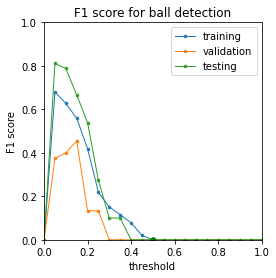

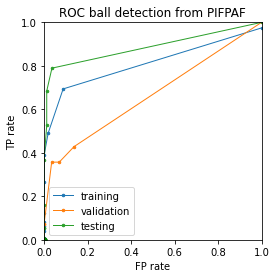

In [13]:
import pickle

filename = "results/resnet50-210313-090501.923457-cifcent-pan-ball-edge641.pkl.epoch247_ball_tmp_results.pickle"
result = pickle.load(open(filename, "rb"))
fig, axes = plt.subplots(2,1)
for subset_name in result:
    plot_F1(result[subset_name], subset_name, axes[0])
    plot_roc(result[subset_name], subset_name, ax)